In [1]:
from pathlib import Path
import random

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
from models.finalpipe import LowBit_RC, TorchPipeline
from models.lfsr import LFSR
from models.pqmf import PQMF

def mtmt(x, lin):
    return lin(x.mT).mT

def nonlin(x):
    return torch.clamp(4*x, -1.0, 1.0)
def reluleak128(x):
    return F.leaky_relu(x, 1.0/128)

STEPS = 1
class FPGA_RC(LowBit_RC):
    def __init__(self):
        super().__init__()
        self.n_bits = 4
        self.seed = 69
        self.feature_pushforward = self._gen_weights()
        # self.register_buffer("feature", torch.zeros(8, 1))

    def _gen_weights(self):
        lfsr = LFSR(seed = self.seed)
        A = torch.tensor([lfsr.gen_fxp_shift(self.n_bits) for _ in range(64)]).reshape(8,8)
        return 0.1* A / torch.linalg.eigvals(A)[0].abs()

    def step(self, x, feat):
        pushed = nonlin(feat @ self.feature_pushforward.T + x)
        return pushed, torch.cat((pushed, reluleak128(pushed)), dim=-1)

    def forward(self, x, fin):
        fout, o = self.step(x, fin)
        return o, fout

In [4]:
class ONNXPipelineStep(TorchPipeline):
    def __init__(self):
        super().__init__()
        self.rc = FPGA_RC()

    def forward(self, x, f):
        bwhitened = self.whiten(x)

        nl_tdyn, fout = self.rc(bwhitened, f)

        ff = reluleak128(self.ff2(reluleak128(self.ff1(bwhitened))))
        # print(x.shape, bwhitened.shape, nl_tdyn.shape, fout.shape, ff.shape)
        stacked = torch.cat((x, bwhitened, 
                             ff, nl_tdyn), dim=-1)

        assimilated = reluleak128(self.preact_norm(self.lin_out(stacked)))

        return  assimilated, fout

class ONNXPipeline(nn.Module):
    def __init__(self):
        super().__init__()
        self.stepper = ONNXPipelineStep()
    def forward(self, x):
        outlist = []
        f = torch.zeros(x.shape[:-1], device=x.device)
        for i in range(x.shape[-1]):
            o, f = self.stepper.forward(x[..., i], f)
            outlist.append(o)
        out = torch.stack(outlist)
        return out.mean(dim=0)


In [224]:
import warnings
from data.augmentations.randphase import AllPassFilter
from torch_audiomentations import *

#FIXME: update transforms
with warnings.catch_warnings(action="ignore"):
    # Initialize augmentation callable
    audio_aug = Compose(
        transforms = [
            PeakNormalization(p=1, output_type="dict"),
            Gain(min_gain_in_db = -1.2, max_gain_in_db=-0.8, p=1, output_type="dict")
            ],
            output_type="dict"
        )

In [225]:
from data.torchfsdd.dataset import TorchFSDDGenerator
pqmf = PQMF(100, 8)
# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(
    version="local",
    path="/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings",
    val_transforms= lambda x: pqmf(audio_aug(x)["samples"]),
)
dset = fsdd.full()
b_rms = lambda x: x.pow(2).mean(dim=-1).mean(dim=-1).sqrt()
NOISE_PROB = 1 / 11
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences, labels = [], torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        labels[i] = label
        seq = sequence
        dice = random.random()
        if dice < NOISE_PROB:
            labels[i] = 10
            seq = pqmf(
                b_rms(seq).unsqueeze(-1).unsqueeze(-1)
                * torch.randn(seq.shape[0], 1, pqmf.n_band * seq.shape[-1])
            )
        sequences.append(seq)

    # Combine sequences into a padded matrix
    stacked_sequences = torch.cat(
        sequences, dim=0
    )  # torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return stacked_sequences, labels

BSIZE = len(dset)
import torch.utils.data as data_utils
loader = data_utils.DataLoader(
        dset, collate_fn=collate_fn, batch_size=BSIZE
    )

In [226]:
X, y = next(iter(loader))

In [5]:
# paramdict = {'bands': 8, 'bits': 4, 'spec_rad': 0.1}
uut =  ONNXPipeline()
def load_model(m, folder, mdevice='cpu'):
    epoch = int(folder.split("epoch")[-1])
    ckpt_path = Path(folder)
    
    ppath = ckpt_path / Path("params")
    pfnames = [f.name for f in ppath.iterdir() if f.is_file()]
    fpnames = [n.split(".ten")[0] for n in pfnames]
    print(ppath, "\n", pfnames, "\n",fpnames)
    print("targeting", [n for n, _ in m.named_parameters()])
    for pname, p in m.named_parameters():
        assert (
            pname in fpnames
        ), f"Unable to locate parameter {pname} in given checkpoint dir"
        loaded = torch.load(ppath / pfnames[fpnames.index(pname)]).to(mdevice)
        print("setting", pname, "to loaded value from", pfnames[fpnames.index(pname)])
        p.data = loaded
    
    
    bpath = ckpt_path / Path("buffs")
    bfnames = [f.name for f in bpath.iterdir() if f.is_file()]
    bnames = [n.split(".ten")[0] for n in bfnames]
    print(bpath, "\n", bfnames, "\n",bnames)
    print("targeting", [n for n, _ in m.named_buffers()])
    for bname, b in m.named_buffers():
        assert (
            bname in bnames
        ), f"Unable to locate parameter {bname} in given checkpoint dir"
        loaded = torch.load(bpath / bfnames[bnames.index(bname)]).to(mdevice)
        print("setting", bname, "to loaded value from", bfnames[bnames.index(bname)])
        b.data = loaded

    return epoch

c:\Users\TheoA\Documents\MIT\SENIORSLIDE\6.S965 Digital Systems Lab II\Final Proj\audio-rc-rtl\exploration\models\lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)


In [6]:
with torch.no_grad():
    load_model(uut.stepper, "models/rc8.65/epoch449")
    uut.eval()

models\rc8.65\epoch449\params 
 ['ff1.bias.tensor', 'ff1.weight.tensor', 'ff2.bias.tensor', 'ff2.weight.tensor', 'lin_out.bias.tensor', 'lin_out.weight.tensor', 'preact_norm.bias.tensor', 'preact_norm.weight.tensor', 'whiten.bias.tensor', 'whiten.weight.tensor'] 
 ['ff1.bias', 'ff1.weight', 'ff2.bias', 'ff2.weight', 'lin_out.bias', 'lin_out.weight', 'preact_norm.bias', 'preact_norm.weight', 'whiten.bias', 'whiten.weight']
targeting ['whiten.weight', 'whiten.bias', 'ff1.weight', 'ff1.bias', 'ff2.weight', 'ff2.bias', 'lin_out.weight', 'lin_out.bias', 'preact_norm.weight', 'preact_norm.bias']
setting whiten.weight to loaded value from whiten.weight.tensor
setting whiten.bias to loaded value from whiten.bias.tensor
setting ff1.weight to loaded value from ff1.weight.tensor
setting ff1.bias to loaded value from ff1.bias.tensor
setting ff2.weight to loaded value from ff2.weight.tensor
setting ff2.bias to loaded value from ff2.bias.tensor
setting lin_out.weight to loaded value from lin_out.wei

In [7]:
sum(p.numel() for p in uut.parameters())

1193

In [230]:
uut, [(n,p.numel(), p.device, p.data) for n,p in uut.named_parameters()], [(n,b.data) for n,b in uut.named_buffers()], 

(ONNXPipeline(
   (stepper): ONNXPipelineStep(
     (whiten): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (rc): FPGA_RC()
     (ff1): Linear(in_features=8, out_features=24, bias=True)
     (ff2): Linear(in_features=24, out_features=16, bias=True)
     (lin_out): Linear(in_features=48, out_features=11, bias=True)
     (preact_norm): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
 ),
 [('stepper.whiten.weight',
   8,
   device(type='cpu'),
   tensor([  7.9661, -14.4477,  58.9429,  26.7822,   9.2949,   7.4669,  13.6542,
            -4.1906])),
  ('stepper.whiten.bias',
   8,
   device(type='cpu'),
   tensor([-0.2031, -0.7289,  0.3803, -0.1120,  0.2329,  0.1502, -0.0222,  0.2523])),
  ('stepper.ff1.weight',
   192,
   device(type='cpu'),
   tensor([[ 1.4736e+00, -5.1501e-01, -3.6763e-01,  7.5883e-01, -2.7664e+00,
            -7.0757e+00, -3.9568e-01, -1.4644e+00],
           [ 3.6301e-01,  5.7049e+00,  1.2449e+00

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

pltr = lambda x: x.cpu().detach().numpy()

In [232]:
acc = []
Xs,ys,yhats=[],[],[]
def testcpu():
    batches=0
    for X, y in loader:
        if X.shape[0] != BSIZE:
            continue
        Xs.append(X)
        ys.append(y)
        yhat = uut(X)
        yhats.append(yhat)
        acc.append((yhat.argmax(-1) == y).sum() / y.numel())
        batches += 1
    return sum(acc)/batches

acc = testcpu()
X, y, yhat = map(torch.cat, (Xs, ys, yhats))
acc, X.shape, y.shape, yhat.shape

(tensor(0.8278),
 torch.Size([2979, 8, 1024]),
 torch.Size([2979]),
 torch.Size([2979, 11]))

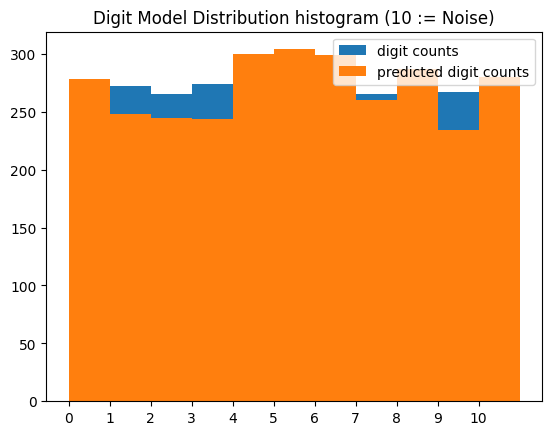

In [233]:
def plothist():
    f, ax = plt.subplots()

    ax.set_title("Digit Model Distribution histogram (10 := Noise)")
    ax.hist(pltr(y.flatten()), bins=np.arange(0, 11 + 1, 1), label="digit counts")
    ax.hist(
            pltr(yhat.argmax(1).flatten()), bins=np.arange(0, 11 + 1, 1), label="predicted digit counts"
        )
    ax.set_xticks(list(map(float, range(11))))
    ax.legend()
    plt.show()
plothist()

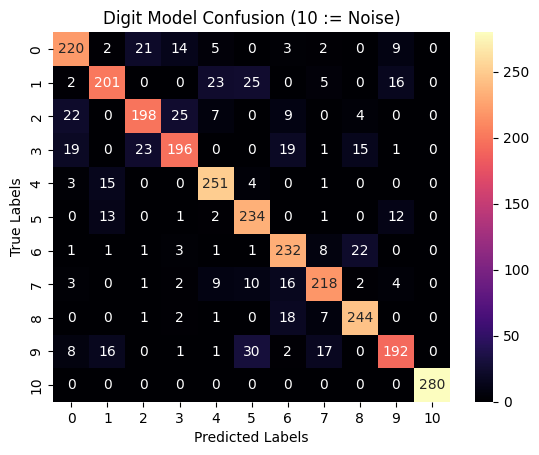

In [234]:
def plotconf():
        pred = pltr(yhat.argmax(1).flatten())
        # Compute confusion matrix
        cm = confusion_matrix(pltr(y.flatten()), pred)

        # Plot confusion matrix
        f, ax = plt.subplots()
        ax.set_title("Digit Model Confusion (10 := Noise)")

        sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="magma",
                xticklabels=np.unique(pltr(y)),
                yticklabels=np.unique(pltr(y)),
                ax=ax,
        )
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")

        plt.show()
plotconf()

In [235]:
uut_1step = uut.stepper

In [240]:
torch.onnx.export(uut_1step, (torch.randn(1, 8), torch.zeros(1, 8)), "1step_pipe.standard.onnx")

In [ ]:
import onnx
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType, QuantFormat
import numpy as np

# Load your model
model_path = '1step_pipe.standard.onnx'
model = onnx.load(model_path)
onnx.shape_inference.infer_shapes(model)

ir_version: 8
opset_import {
  version: 17
}
producer_name: "pytorch"
producer_version: "2.1.1"
graph {
  node {
    input: "input.1"
    input: "whiten.weight"
    input: "whiten.bias"
    input: "whiten.running_mean"
    input: "whiten.running_var"
    output: "/whiten/BatchNormalization_output_0"
    name: "/whiten/BatchNormalization"
    op_type: "BatchNormalization"
    attribute {
      name: "epsilon"
      type: FLOAT
      f: 1e-05
    }
    attribute {
      name: "momentum"
      type: FLOAT
      f: 0.9
    }
    attribute {
      name: "training_mode"
      type: INT
      i: 0
    }
  }
  node {
    output: "/rc/Constant_output_0"
    name: "/rc/Constant"
    op_type: "Constant"
    attribute {
      name: "value"
      type: TENSOR
      t {
        dims: 8
        dims: 8
        data_type: 1
        raw_data: "GB6=GB6\272GB\266\275GB\266\275GB6;GB6=GB6=GB\266\272GB\266\273GB6\272GB6<GB6\274GB\266\274GB6\274GB\266<GB\266:GB6:GB6:GB6<GB\266;GB\266<GB\266\275GB6<GB\266:GB

In [270]:
import onnxruntime as ort
class ONNXModelWrapper(torch.nn.Module):
    def __init__(self, onnx_model_path):
        super(ONNXModelWrapper, self).__init__()
        self.session = ort.InferenceSession(onnx_model_path)
        self.input_names = tuple(i.name for i in self.session.get_inputs())
        self.output_names = tuple(o.name for o in self.session.get_outputs()) 

    def forward(self, x, f):
        # Convert PyTorch tensor to NumPy array
        ort_inputs = {self.input_names[0]: x.detach().cpu().numpy(),
                      self.input_names[1]: f.detach().cpu().numpy()}
        # Run inference
        ort_out, ort_f = self.session.run(self.output_names, ort_inputs)
        # Convert NumPy array back to PyTorch tensor
        return torch.tensor(ort_out), torch.tensor(ort_f)

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)
2024-12-07 19:16:57.263835011 [W:onnxruntime:, graph.cc:4285 CleanUnusedInitializersAndNodeArgs] Removing initializer '/rc/Constant_3_output_0'. It is not used by any node and should be removed from the model.
2024-12-07 19:16:57.263872861 [W:onnxruntime:, graph.cc:4285 CleanUnusedInitializersAndNodeArgs] Removing initializer '/rc/Constant_2_output_0'. It is not used by any node and should be removed from the model.


In [278]:
ouut = ONNXPipeline()
ouut.stepper = ONNXModelWrapper("1step_pipe.standard.onnx")

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)


In [ ]:
def testmodel(samples, m):
    acc = []
    Xs,ys,yhats=[],[],[]
    batches=0
    loader = data_utils.DataLoader(
        dset, collate_fn=collate_fn, batch_size=1
    )
    if samples < 1:
        samples = len(dset)
    for X, y in loader:
        if batches>samples:
            break
        Xs.append(X)
        ys.append(y)
        yhat = m(X)
        yhats.append(yhat)
        acc.append((yhat.argmax(-1) == y).sum() / y.numel())
        batches += 1

    return sum(acc)/samples, *map(torch.cat, (Xs, ys, yhats))

acc, X, y, yhat = testmodel(-1, ouut)
acc, X.shape, y.shape, yhat.shape

(tensor(0.8800),
 torch.Size([101, 8, 1024]),
 torch.Size([101]),
 torch.Size([101, 11]))

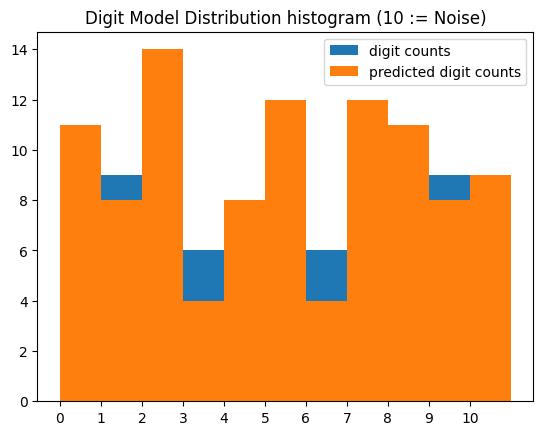

In [280]:
plothist()

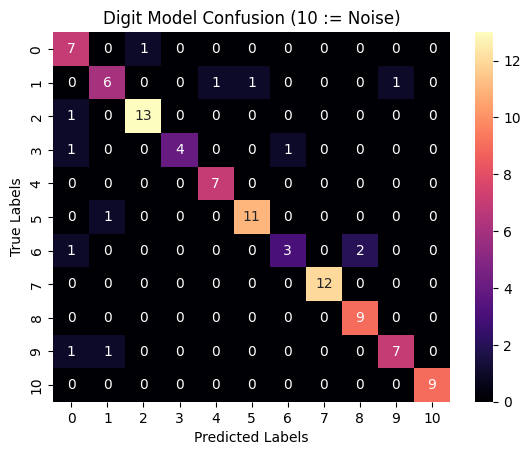

In [281]:
plotconf()

In [ ]:
class DataReader(CalibrationDataReader):
    def __init__(self, calibration_data):
        self.data = calibration_data
        self.enum_data = iter(self.data)

    def get_next(self):
        data = next(self.enum_data, None)
        if data is not None:
            return {'input.1': data[0], 'fin': data[1]}
        return None

# Prepare calibration data
calibration_data = [(pltr(X[i, :, j].unsqueeze(0)).astype(np.float32), 
                     np.zeros((1, 8), np.float32)) 
                    for i in range(X.shape[0]//4) for j in range(100)]  # Example data
data_reader = DataReader(calibration_data)

# Quantize the model
quantized_model_path = '1step_pipe.quantized.onnx'
quantize_static(model_path, quantized_model_path, data_reader, 
                weight_type=QuantType.QInt8, 
                quant_format=QuantFormat.QOperator, 
                per_channel=False,
                activation_type=QuantType.QInt8)

# print(f"Quantized model saved to {quantized_model_path}")

In [ ]:
quantized_model = onnx.load_model("1step_pipe.standard.onnx")
onnx.shape_inference.infer_shapes(quantized_model)

ir_version: 8
opset_import {
  version: 17
}
opset_import {
  domain: "com.microsoft"
  version: 1
}
producer_name: "onnx.quantize"
producer_version: "0.1.0"
graph {
  node {
    output: "/rc/Constant_output_0"
    name: "/rc/Constant"
    op_type: "Constant"
    attribute {
      name: "value"
      type: TENSOR
      t {
        dims: 8
        dims: 8
        data_type: 1
        raw_data: "GB6=GB6\272GB\266\275GB\266\275GB6;GB6=GB6=GB\266\272GB\266\273GB6\272GB6<GB6\274GB\266\274GB6\274GB\266<GB\266:GB6:GB6:GB6<GB\266;GB\266<GB\266\275GB6<GB\266:GB\266;GB6;GB6=GB6\273GB\266;GB6\274GB6\274GB6;GB\266\275GB6=GB\266:GB6:GB\266;GB6=GB\266:GB6\274GB\266\274GB\266\272GB6:GB6\274GB6\275GB6;GB\266\274GB\266\272GB6\273GB6;GB6\275GB\266=GB6<GB6\275GB\266:GB\266\275GB6\275GB6\273GB6:GB6\275GB6\275GB\266\273GB6;GB\266<"
      }
    }
  }
  node {
    output: "/rc/Constant_1_output_0"
    name: "/rc/Constant_1"
    op_type: "Constant"
    attribute {
      name: "value"
      type: TENSOR
      

In [310]:
quut = ONNXPipeline()
quut.stepper = ONNXModelWrapper("1step_pipe.quantized.onnx")

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)
2024-12-07 19:29:42.939242925 [W:onnxruntime:, graph.cc:4285 CleanUnusedInitializersAndNodeArgs] Removing initializer '/rc/Constant_3_output_0'. It is not used by any node and should be removed from the model.
2024-12-07 19:29:42.939293785 [W:onnxruntime:, graph.cc:4285 CleanUnusedInitializersAndNodeArgs] Removing initializer '/rc/Constant_2_output_0'. It is not used by any node and should be removed from the model.


In [ ]:
acc, X, y, yhat = testmodel(-1, quut)
acc, X.shape, y.shape, yhat.shape

(tensor(0.7280),
 torch.Size([1001, 8, 1024]),
 torch.Size([1001]),
 torch.Size([1001, 11]))

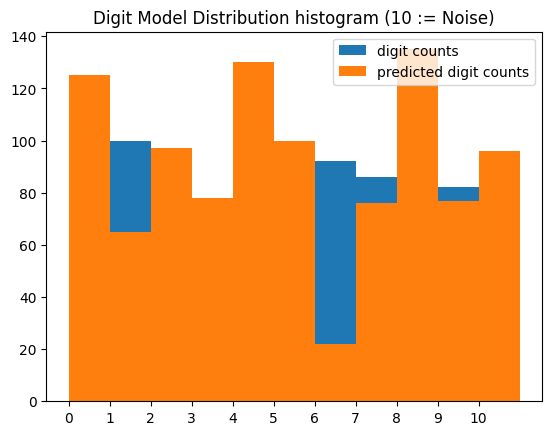

In [312]:
plothist()

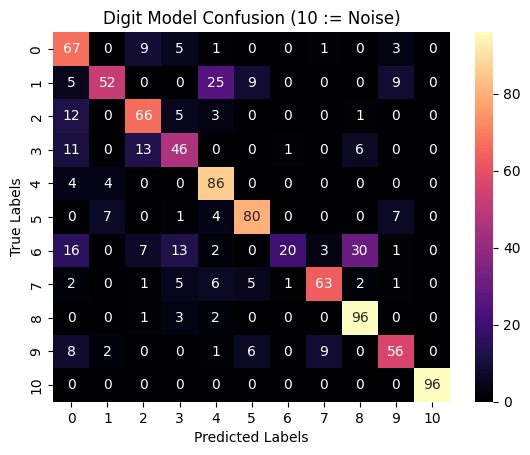

In [313]:
plotconf()